In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pymongo import MongoClient

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Gather all datapoints from all datasets & group by cell_line and gene

In [5]:
client = MongoClient(maxPoolSize=500)

In [ ]:
ALL_SUBCELL_GENES_COLLECTION = "splice_isoforms"
all_proteoform_results = client.hpa[ALL_SUBCELL_GENES_COLLECTION].aggregate(
    [
        {"$unwind": "$cell_lines"},  # Deconstruct the cell_lines array field
        {"$group": {
            "_id": "$_id",
            "cell_line_names": {"$push": "$cell_lines.name"}  # Collect the cell_lines.name values into an array
        }
        }
    ]
)

In [ ]:
ALL_SUBCELL_GENES_COLLECTION = "genes"
all_genes_result = client.hpa_old[ALL_SUBCELL_GENES_COLLECTION].aggregate(
    [
        {
            "$group": {
                "_id": "$Gene name",
                "count": {"$sum": "1"},
            }
        }
    ]
)

In [ ]:
TRAINING_COLLECTION_NAME = "splice_isoform_dataset_cell_line_and_gene_split_full"
train_result = client.hpa_old[TRAINING_COLLECTION_NAME].aggregate(
    [
        {
            "$group": {
                "_id": "$cell_line",
                "dataset_split": {"$addToSet": "$_id"},
                "splice_isoform_id": {"$addToSet": "$splice_isoform_id"},
            }
        }
    ]
)

In [ ]:
RANDOM_COLLECTION_NAME = "random_splice_isoform_dataset"
random_result = client.hpa[RANDOM_COLLECTION_NAME].aggregate(
    [
        {
            "$group": {
                "_id": "$cell_line",
                "dataset_split": {"$addToSet": "$_id"},
                "splice_isoform_id": {"$addToSet": "$splice_isoform_id"},
            }
        }
    ]
)

In [ ]:
import pdb
from collections import defaultdict

dataset_record = {
    'train': defaultdict(lambda: defaultdict(bool)),
    'test': defaultdict(lambda: defaultdict(bool)),
    'eval': defaultdict(lambda: defaultdict(bool)),
    'random_test': defaultdict(lambda: defaultdict(bool)),
    'all_proteoforms': defaultdict(lambda: defaultdict(bool)),
}


# Lookup dictionary for deduplicating cell lines
cell_line_lookup = {
    "BJ[Human Fibroblast]": "BJ",
    "BJ[Humanfibroblast]": "BJ",
    "HUVECTERT2": "HUVEC/TERT2",
    "Rh30": "RH30",
    "RPTECTERT1": "RPTEC/TERT1",
    "hTERTRPE1(serumstarved)": "hTERTRPE1",
}

def extract_gene_id(splice_isoform_id):
    return '-'.join(splice_isoform_id.split('-')[:-1])

get_split = lambda x: x.split("_")[0]

for doc in train_result:
    split = list(set(get_split(data_id) for data_id in doc["dataset_split"]))
    assert len(split) == 1, "Each cell line only belongs to one dataset!"
    cell_line = cell_line_lookup.get(doc["_id"], doc["_id"])
    gene_set = set(extract_gene_id(proteoform) for proteoform in doc['splice_isoform_id'])

    data_dict = dataset_record[split[0]]
    for gene in list(gene_set):
        data_dict[cell_line][gene] = True

random_gene_to_proteoforms = {}
for doc in random_result:
    split = list(set(get_split(data_id) for data_id in doc["dataset_split"]))
    assert len(split) == 1, "Each cell line only belongs to one dataset!"
    cell_line = cell_line_lookup.get(doc["_id"], doc["_id"])
    gene_set = set(extract_gene_id(proteoform) for proteoform in doc['splice_isoform_id'])
    for proteoform in doc['splice_isoform_id']:
        random_gene_to_proteoforms[gene] = random_gene_to_proteoforms.get(gene, []) + [proteoform]

    data_dict = dataset_record['random_test']
    for gene in list(gene_set):
        data_dict[cell_line][gene] = True

gene_set = []
# Ensure all genes are included
for doc in all_genes_result:
    gene_set.append(doc['_id'])

gene_set = set(gene_set)

for doc in all_proteoform_results:
    cell_lines = [cell_line_lookup.get(cell_line, cell_line) for cell_line in doc['cell_line_names']]
    gene = extract_gene_id(doc["_id"])

    data_dict = dataset_record['all_proteoforms']
    for cell_line in cell_lines:
        data_dict[cell_line][gene] = True


In [ ]:
dataset_record = {
    'train': pd.DataFrame.from_dict(dataset_record['train'], orient='index').fillna(False),
    'test': pd.DataFrame.from_dict(dataset_record['test'], orient='index').fillna(False),
    'eval': pd.DataFrame.from_dict(dataset_record['eval'], orient='index').fillna(False),
    'random_test': pd.DataFrame.from_dict(dataset_record['random_test'], orient='index').fillna(False),
    'all_proteoforms': pd.DataFrame.from_dict(dataset_record['all_proteoforms'], orient='index').fillna(False),
}

In [ ]:
client.close()

## Combine all datasets

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# Combine DataFrames
train_df = pd.DataFrame(dataset_record['train'])
test_df = pd.DataFrame(dataset_record['test'])
eval_df = pd.DataFrame(dataset_record['eval'])
random_test_df = pd.DataFrame(dataset_record['random_test'])
all_proteoforms_df = pd.DataFrame(dataset_record['all_proteoforms'])



In [ ]:
def sort_dataframe(df):
    return df.sort_index(key=lambda x: x.str.lower()).sort_index(axis=1, key=lambda x: x.str.lower())

final_train_datapoint = 'GATD3A' # FZD2	FZD3	FZD8	FZR1	GASK1A	GASK1B	GATD3A	GOLM2	IHO1	IMPAD1
existing_genes = gene_set.difference(set(train_df.columns).union(set(test_df.columns)).union(set(eval_df.columns)))
training_fill_in_genes = [col for col in existing_genes if col.lower() <= final_train_datapoint.lower()]
filledin_train_df = train_df.reindex(columns=train_df.columns.union(training_fill_in_genes))

In [ ]:
after_cutoff_columns = [col for col in train_df.columns if col.lower() >= final_train_datapoint.lower()]
sorted(after_cutoff_columns)

['GATD3A',
 'GOLM2',
 'IHO1',
 'IMPAD1',
 'INKA1',
 'ISPD',
 'ITPRID1',
 'KIAA1211L',
 'KIAA1324',
 'LRATD1',
 'SCYL3',
 'TSPAN6']

In [ ]:
eval_df

,DAP,ELAVL2,ASCC2,DCUN1D1,FAAH,ARFGEF1,ASPA,DDX42,ECSIT,ANKRD49,...,ENO1,DENND5A,EEF2K,ACAP3,CDKN2B,CAMLG,DLGAP4,FMC1-LUC7L2,C1orf100,ESRRB
A431,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
HeLa,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,False,False
HUVEC/TERT2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
K562,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [ ]:
test_df

,B4GALT5,CPA3,CD36,FANCE,C2orf16,CT47A6,CRYGC,CT47A11,CT47B1,BIN2,...,COQ10A,FANCF,CRACD,CELF4,ANKRD45,FAM163B,DUSP12,FEM1A,ESRRG,CELF3
hTERTRPE1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
HEL,False,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
RH30,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
HUVEC/TERT2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
MCF7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SHSY5Y,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
BJ,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
PC3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_genes = [col.lower() for col in train_df.columns]
random_test_drop_columns = [col for col in random_test_df.columns if col.lower() in train_genes]
filtered_random_test_df = random_test_df.drop(columns=random_test_drop_columns)
filtered_random_test_df

,NEXN,RTN4,NT5E,RDH5,TMEM196,SERINC2,PPP1R3D,SPON2,KCNK7,CYP27C1,...,SLC35D3,IMMT,HSPBP1,TICRR,POLD1,TTC24,CATSPERB,GJB6,TMEM63A,SLC25A35
ASCTERT1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
U251MG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BJ,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
RH30,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
U2OS,True,True,True,True,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
LHCNM2,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A431,False,False,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ASC52telo,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SKMEL30,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
HaCaT,False,False,False,False,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
gene_set = filtered_random_test_df.columns
filtered_dataset = []
for doc in random_result:
    for proteoform in doc['splice_isoform_id']:
        gene = extract_gene_id(proteoform)
        if gene in gene_set:
            filtered_dataset.append((doc['_id'], proteoform))

In [ ]:
len(set(filtered_dataset))

24008

In [ ]:
combined_df = pd.DataFrame()

def append_dataframe_horizontally(base_df, new_df):
    new_df = sort_dataframe(new_df)
    combined_index = base_df.index.append(new_df.index).unique()
    base_df = base_df.reindex(combined_index)
    new_df = new_df.loc[:, ~new_df.columns.isin(base_df.columns)]
    return pd.concat([base_df, new_df], axis=1).fillna(0)

# Append each dataframe horizontally
combined_df = append_dataframe_horizontally(combined_df, filledin_train_df)
combined_df = append_dataframe_horizontally(combined_df, test_df)
combined_df = append_dataframe_horizontally(combined_df, eval_df)

# add all of the thithertoo unseen genes in with the random_test_df
remaining_genes = gene_set.difference(combined_df.columns)
filtered_random_test_df = filtered_random_test_df.reindex(columns=filtered_random_test_df.columns.union(remaining_genes).union(all_proteoforms_df.columns))


combined_df = append_dataframe_horizontally(combined_df, filtered_random_test_df)
combined_df = combined_df.replace(False, 0)


In [ ]:
combined_df

,A1CF,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AANAT,AAR2,AARD,...,ZW10,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A549,0,0,0,0,0.0,0,0,True,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AF22,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASC52telo,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ASCTERT1,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BJ,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CACO2,True,0,0,0,0.0,0,0,0,True,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EFO21,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GAMG,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HaCaT,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HAP1,0,0,0,0,0.0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Mark the presence in the combined DataFrame
for df, value in zip([all_proteoforms_df, train_df, test_df, eval_df, filtered_random_test_df], [5, 1, 2, 3, 4]):
    for cell_line in df.index:
        for proteoform in df.columns:
            if not pd.isna(df.at[cell_line, proteoform]) and df.at[cell_line, proteoform]:
                combined_df.at[cell_line, proteoform] = value

combined_df = combined_df.apply(pd.to_numeric, errors='coerce').fillna(0)


In [ ]:
x_indices = []
x_labels = []

current_letter = combined_df.columns[0][0].upper()

# Iterate over columns to find indices where a new letter begins
for i, col in enumerate(combined_df.columns):
    first_letter = col[0].upper()
    if first_letter != current_letter:
        x_indices.append(i)
        x_labels.append(col)
        current_letter = first_letter

if x_indices[0] != 0:
    x_indices.insert(0, 0)
    x_labels.insert(0, combined_df.columns[0])

print("x_indices:", x_indices)
print("x_labels:", x_labels)


x_indices: [0, 943, 1169, 2504, 2939, 3283, 3751, 3853, 3858, 3860, 3861, 3862, 3863, 3923, 3940, 4023, 4062, 4091, 4129, 4130, 4131, 4198, 4213, 4290, 4321, 4349, 4373, 4374, 4383, 4384, 4389, 4390, 4391, 4398, 4817, 5260, 5590, 5627, 5959, 6328, 7118, 7720, 7860, 9045, 9060, 9801, 11147, 12193, 12418, 12521, 12638, 12675, 12715]
x_labels: ['A1CF', 'B2M', 'C10orf62', 'D2HGDH', 'E2F1', 'F11', 'G2E3', 'IHO1', 'KIAA1211L', 'LRATD1', 'SCYL3', 'TSPAN6', 'A4GALT', 'B3GAT1', 'C10orf71', 'DAAM1', 'E2F5', 'F2RL3', 'GET3', 'KIAA0141', 'ABCD3', 'B3GALNT1', 'C12orf10', 'DAND5', 'ECHDC2', 'FAAH', 'ILRUN', 'AC004593.3', 'BHMG1', 'C15orf59', 'DOPEY1', 'ELOA3C', 'FAM129B', 'GARS', 'H1-0', 'IAH1', 'JADE1', 'KALRN', 'L1CAM', 'M1AP', 'N4BP1', 'OAF', 'P2RX1', 'QARS', 'R3HCC1', 'S100A1', 'TAB1', 'U2AF1', 'VAC14', 'WAC', 'XAB2', 'YAE1', 'Z82206.1']


In [ ]:
import numpy as np 
# Reorder rows by # of elements
combined_df['non_zero_count'] = combined_df.apply(lambda row: np.count_nonzero(row), axis=1)
combined_df = combined_df.sort_values(by='non_zero_count', ascending=False)
combined_df = combined_df.drop(columns=['non_zero_count'])

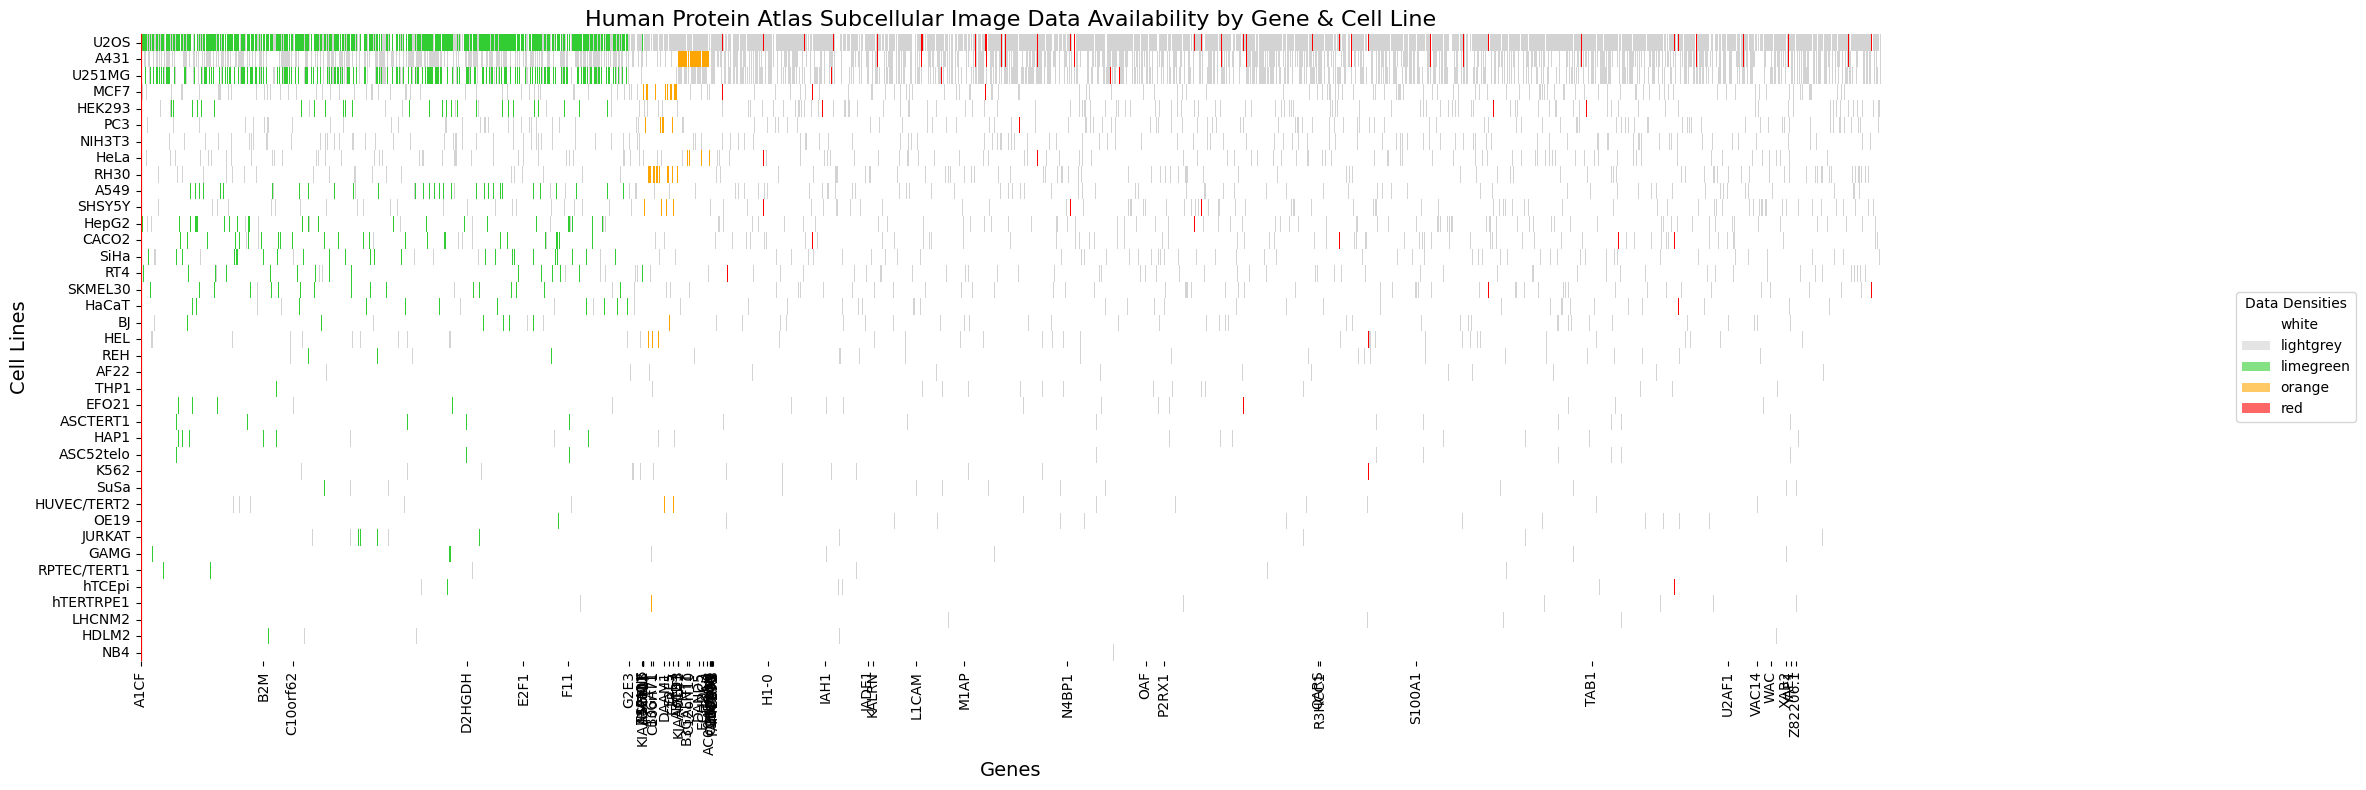

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

# Assuming combined_df is your DataFrame
plt.figure(figsize=(24, 8))

# Create the main heatmap
cmap = sns.color_palette(["white", "limegreen", "orange", "orange", "red", "lightgrey"])
ax = sns.heatmap(combined_df, cmap=cmap, linewidths=0.0, linecolor='gray', cbar=False, annot=False)

plt.title("Human Protein Atlas Subcellular Image Data Availability by Gene & Cell Line", fontsize=16)
plt.xlabel("Genes", fontsize=14)
plt.ylabel("Cell Lines", fontsize=14)
x_indices = range(combined_df.shape[1])
x_labels = combined_df.columns
plt.xticks(ticks=x_indices, labels=x_labels, rotation=90)
plt.yticks(rotation=0)

legend_elements = [
    Patch(facecolor='white', edgecolor='gray', label='Absent in HPA'),
    Patch(facecolor='lightgrey', edgecolor='gray', label='Present in HPA'),
    Patch(facecolor='limegreen', edgecolor='gray', label='Train'),
    Patch(facecolor='orange', edgecolor='gray', label='Holdout 1'),
    Patch(facecolor='red', edgecolor='gray', label='Holdout 2'),
]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title='Dataset')

colors = ['white', 'lightgrey', 'limegreen', 'orange', 'red']
value_counts = combined_df.apply(pd.Series.value_counts).fillna(0).T
normalized_counts = value_counts.div(value_counts.sum(axis=1), axis=0)
for i, color in enumerate(colors):
    sns.histplot(data=normalized_counts, y=normalized_counts.index, weights=normalized_counts.iloc[:, i], 
                 kde=True, color=color, label=color, alpha=0.6, linewidth=0)

plt.legend(title='Data Densities', loc='upper left', bbox_to_anchor=(1.2, 0.6))

plt.tight_layout()
plt.show()